In [1]:
import torch
import os
import torchvision
import numpy as np
from PIL import Image
import xml.etree.ElementTree as ET
from pylab import *

import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

import glob
import os

image_size = (64,64)

In [2]:
class kangaroo(Dataset):
    
    def __init__(self, path, transform):
        image_dir = path + '/kangaroo/images' #path to images
        annotation_dir = path + '/kangaroo/pascal'#path to annotation.xml files
        self.transform = transform #transforms passed to the initializer
        # list all the files in the folder, sort the files in alphabetical order and join the file name with folder name
        # for image
        self.image_names = os.listdir(image_dir)
        self.image_names.sort()
        self.image_names = [os.path.join(image_dir,image_name) for image_name in self.image_names]
        # for annotation.xml files
        self.annotation_names = os.listdir(annotation_dir)
        self.annotation_names.sort()
        self.annotation_names = [os.path.join(annotation_dir,annotation_name) for annotation_name in self.annotation_names]
    
    #create a custom dataset with labels   
    def __getitem__(self, idx):
        #load images from the folder
        image_name = self.image_names[idx]
        img = Image.open(image_name) 
        #load annotations from the folder
        annotation_name = self.annotation_names[idx]
        annotation_tree = ET.parse(annotation_name, ET.XMLParser(encoding='utf-8'))
        classes = annotation_tree.find("object").find("name").text #parse the class labels
        list_classes = [classes] #converting string to list
        num_obj = len(list_classes) #read the number of labels
        bndbox_xml = annotation_tree.find("object").find("bndbox") #parse the bounding box
        xmin = int(bndbox_xml.find('xmin').text)
        ymin = int(bndbox_xml.find('ymin').text)
        xmax = int(bndbox_xml.find('xmax').text)
        ymax = int(bndbox_xml.find('ymax').text)
        bbox = (xmin, ymin, xmax, ymax)
        img.crop(bbox) #crop the images with boundary box
        if self.transform:
            img = self.transform(img)  #apply the transforms to the image  
        labels = torch.ones((num_obj), dtype=torch.int64) #convert the int label to tensor
        return img, labels
    
    def __len__(self):
        return len(self.image_names)
        

In [3]:
#mean and std from imagenet to normalize the images
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
transform = transforms.Compose([
                                transforms.Resize(image_size), #64*64
                                transforms.ToTensor(), 
                                transforms.Normalize(mean, std)])
path = '/Users/nivin/Documents/Object Detection' #the path to the files
dataset = kangaroo(path,transform = transform) # Initialize the dataset and transform each images to tensor
print(len(dataset))

139


In [4]:
#sample of images from the dataset
def imshow(source):
    plt.figure(figsize=(10,10))
    imt = (source.view(-1, image_size[0], image_size[0]))
    imt = imt.numpy().transpose([1,2,0])
    imt = (std * imt + mean).clip(0,1)
    plt.subplot(1,2,2)
    plt.imshow(imt)

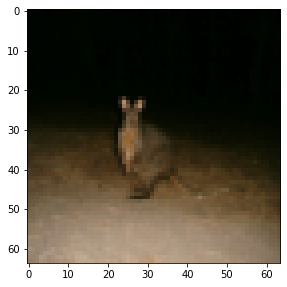

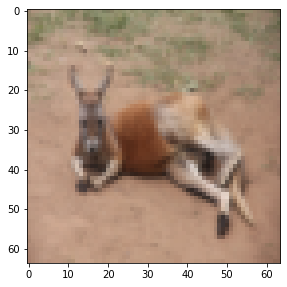

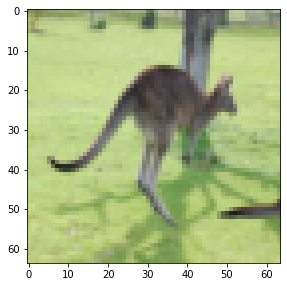

In [5]:
imshow(dataset[1][0])
imshow(dataset[2][0])
imshow(dataset[13][0])

In [6]:
#split the dataset for training and validation
train_set = int(0.8 * len(dataset)) # 80% for training
val_set = len(dataset) - train_set # 20% for validation
print(train_set)
print(val_set)
#Hyperparameter
batch_size = 2
train_data, val_data = torch.utils.data.random_split(dataset, [train_set, val_set]) #random split the data into non-overlapping datasets
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True) #configuring train loader : Batch size of 2 images
validationloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True) #configuring validation loader :  Batch size of 2 images

111
28


In [7]:
# the proposed network has two main convolutional layers and two fully connected linear layers, the number of nodes in layer 1
# is 512 and the number of nodes in  layer 2 is 256. A dropout of 40% is used to avoid overfitting of dataset and a maxpooling
# with 2x2 is used to reduce the dimension of the image and also to avoid overfitting
import torch.optim as optim
class Net(nn.Module): #create a class
    def __init__(self): #initialise the class
        super(Net, self).__init__()
        #Main Layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 512, 5), 
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        #Main Layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(512, 256, 5),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        self.drop_out = nn.Dropout(p=0.40)
        # Two fully connected layer
        self.fc1 = nn.Linear(43264, 120)
        self.fc2 = nn.Linear(120, 1)

    def forward(self, x):
        out = self.layer1(x) #pass through convolutional layers
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1) #Flatten the output from convolutional layers to linear fully connected layers 
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
model = Net() #creating an instance for the model
print(model)

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 512, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(512, 256, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=43264, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=1, bias=True)
)


In [8]:
#Hyperparameters
epochs = 5
lr = 0.0002
momentum = 0.9
weight_decay = 0.00001

#Loss function BCEWithLogitsLoss that combines Sigmoid layer and the BCELoss in one single class. Binary Cross Entrophy
# (BCE) calculates the binary entrophy between the target and output
criterion = nn.BCEWithLogitsLoss()

# Optimizer: stochastic gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = momentum, weight_decay = weight_decay)

In [9]:
train_loss = []
testing_loss = []
testaccuracy = []
epochs = 5
test_loss = 0
period = 5
def train(model, epochs):
    for epoch in range(epochs):
        train_loss = 0.0
        count = 0
        for idx, iteration in enumerate(trainloader):
            count = count + 1
            x, label = iteration
            optimizer.zero_grad()# zero gradients of optimiser
            pred_label = model(x)# forward propogation
            loss = criterion(pred_label, label.float())     # compute loss 
            loss.backward()     # find rate of change of loss with respect to model parameters - backward propogation
            optimizer.step()#optimisation step -> optimise the weights and bias
            train_loss += loss.item()*x.size(0)
            if count % period == 0: # Print every 5 iterations
                test_loss = 0
                accuracy = 0
                model.eval() #set to evaluation mode
                with torch.no_grad():
                    for idx,iteration in enumerate(validationloader):
                        x, label = iteration
                        pred_label = model(x)  #forward propogation
                        val_loss = criterion(pred_label, label.float())# compute loss 
                        test_loss += val_loss.item()*x.size(0)
                train_loss = train_loss/period
                test_loss = test_loss/len(validationloader)
                testing_loss.append(test_loss)
                #print the result
                print('Epoch: {} \t Step: {} \tTrain Loss: {:.6f} \tTest loss: {:.6f}'.format(
                        epoch+1,
                        count,
                        train_loss,
                        test_loss,
                        ))
train(model, epochs)

Epoch: 1 	 Step: 5 	Train Loss: 1.195784 	Test loss: 0.798389
Epoch: 1 	 Step: 10 	Train Loss: 0.917919 	Test loss: 0.285524
Epoch: 1 	 Step: 15 	Train Loss: 0.355111 	Test loss: 0.087684
Epoch: 1 	 Step: 20 	Train Loss: 0.156697 	Test loss: 0.031929
Epoch: 1 	 Step: 25 	Train Loss: 0.071214 	Test loss: 0.015026
Epoch: 1 	 Step: 30 	Train Loss: 0.019481 	Test loss: 0.009177
Epoch: 1 	 Step: 35 	Train Loss: 0.006757 	Test loss: 0.006728
Epoch: 1 	 Step: 40 	Train Loss: 0.008856 	Test loss: 0.005474
Epoch: 1 	 Step: 45 	Train Loss: 0.004745 	Test loss: 0.004762
Epoch: 1 	 Step: 50 	Train Loss: 0.011592 	Test loss: 0.004284
Epoch: 1 	 Step: 55 	Train Loss: 0.004159 	Test loss: 0.003942
Epoch: 2 	 Step: 5 	Train Loss: 0.006047 	Test loss: 0.003665
Epoch: 2 	 Step: 10 	Train Loss: 0.006668 	Test loss: 0.003471
Epoch: 2 	 Step: 15 	Train Loss: 0.004646 	Test loss: 0.003312
Epoch: 2 	 Step: 20 	Train Loss: 0.002490 	Test loss: 0.003194
Epoch: 2 	 Step: 25 	Train Loss: 0.002067 	Test loss: 0.0

In [10]:
checkpoint = {
    'parameters' : model.parameters,
    'state_dict' : model.state_dict()
}

In [11]:
torch.save(checkpoint, './kangaroo.pth')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
